In [1]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras import backend as K 

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *

In [2]:
def plot_confusion_matrix(cm, class_names, title="Confusion matrix"):
    fig, ax  = plt.subplots(figsize=(4,4))
    heatmap = sn.heatmap(cm, annot=True,fmt='g', cmap='Blues', ax=ax,cbar=False)
    
    ax.set_title(title)
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
    
    heatmap.set_xticklabels(class_names)
    heatmap.set_yticklabels(class_names)

In [3]:
def get_best_cross_val_model(model_paths, model_name, scores, custom_objects=None):
    losses, accs = zip(*results)
    index = np.argmax(accs)
    return load_model(os.path.join(model_paths, model_name + '_' + str(index) + '.h5'), custom_objects=custom_objects)

In [4]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15807252865348396970
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7785862944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7305155304687550442
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [7]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'transfer_learning')
#IMAGES_DIR = 'D:\\fall_images' # For 64x64 images
IMAGES_DIR = 'images'
#IMAGES_DIR = 'D:\img32' # For 32x32 images

## Load base model

In [21]:
source_model = load_model("transfer_learning_model/dense_ms_from_scratch.209-0.990.hdf5", compile=False)
source_model.trainable = False

In [22]:
source_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [23]:
def create_model():
    # Add new layer to pre-trained network
    flat1 = Flatten()(source_model.layers[-3].output)
    dropout_flatten = Dropout(0.5)(flat1)

    dense256 = Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
    dropout256 = Dropout(0.5)(dense256)

    dense32 = Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout256)
    dropout32 = Dropout(0.5)(dense32)

    output = Dense(1, activation='sigmoid')(dropout32)

    return Model(inputs=source_model.input, outputs=output)

# Coffee vs other
## Model creation

In [41]:
model = create_model()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

### Run only for modify input shape

In [ ]:
model = change_model(model, new_input_shape=(None, 32,32,13))
model.summary()

## Load Data

In [15]:
PATH_COFFEE = os.path.join(IMAGES_DIR, '2')
path1 = [os.path.join(PATH_COFFEE, s) for s in os.listdir(PATH_COFFEE)]
np.random.shuffle(path1)
class1 = [0]*len(path1)

In [16]:
other_class_dir = list(range(1,32))
other_class_dir.remove(2)
path2 = []

for p in other_class_dir:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(p))):
        path2.append(os.path.join(IMAGES_DIR, str(p), name))
        
path2 = random.sample(path2, len(path1)) # Take the same number of img as class 0
random.shuffle(path2)
class2 = [1]*len(path2)

In [17]:
file_paths = np.asarray(path1 + path2)
classes = np.asarray(class1 + class2)
path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.20)

In [101]:
# Params
BATCH_SIZE = 64
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
EPOCH = 100
RUN_NAME = 'test'
LOGS_PATH = 'logs'

In [102]:
train_generator = generator(path_train, 
                            y_train, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE, 
                            is_data_augmentation=True)

test_generator = generator(path_test, 
                           y_test, 
                           eurosat_params['mean'], 
                           eurosat_params['std'], 
                           batch_size=BATCH_SIZE, 
                           is_data_augmentation=False)

In [103]:
earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
#tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

In [ ]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper])

Epoch 1/100
 77/147 [==============>...............] - ETA: 9s - loss: 2.4839 - accuracy: 0.6449

In [28]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))

model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.npy'),history.history)

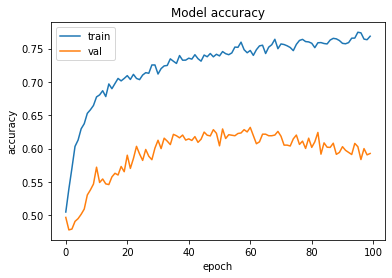

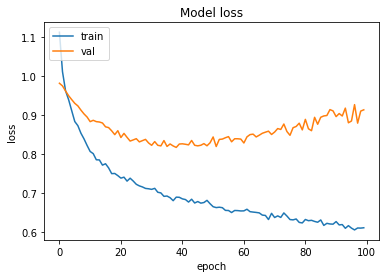

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model evaluation

In [17]:
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
model.evaluate_generator(test_generator,30)

[0.6172418137391408, 0.7651042]

In [32]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(final_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [33]:
cm = confusion_matrix(Y_true, Y_pred)

In [34]:
cm

array([[944,  43],
       [473, 460]], dtype=int64)

In [35]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.67      0.96      0.79       987
           1       0.91      0.49      0.64       933

    accuracy                           0.73      1920
   macro avg       0.79      0.72      0.71      1920
weighted avg       0.79      0.73      0.72      1920

F1-Score : 0.6406685236768802


## Cross val

In [30]:
data_train = pd.read_csv(os.path.join('datasets', 'all_train.csv'))
data_test = pd.read_csv(os.path.join('datasets', 'all_test.csv'))

path_train = data_train['path_train'].to_numpy()
y_train = data_train['y_train'].to_numpy()

path_test = data_test['path_test'].to_numpy()
y_test = data_test['y_test'].to_numpy()

In [26]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'final_cv_coffee__1'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))

In [31]:
kf = KFold(n_splits=NB_FOLD)

fold_index = 0

results = []

for train_index, validation_index in kf.split(path_train, y_train):
    
    print(f"Training for fold {fold_index}")

    train_generator = generator(path_train[train_index], 
                                y_train[train_index], 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)

    validation_generator = generator(path_train[validation_index], 
                               y_train[validation_index], 
                               eurosat_params['mean'], 
                               eurosat_params['std'], 
                               batch_size=BATCH_SIZE, 
                               is_data_augmentation=False)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
    
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=int(len(path_train[train_index])/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=int(len(path_train[validation_index])/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print("\n")

    
    K.clear_session()

    
    fold_index+=1


Training for fold 0
Epoch 1/100
117/117 [==============================] - 27s 182ms/step - loss: 3.0646 - accuracy: 0.5066 - val_loss: 1.2235 - val_accuracy: 0.6765
Epoch 2/100
117/117 [==============================] - 19s 165ms/step - loss: 2.0244 - accuracy: 0.5467 - val_loss: 0.9667 - val_accuracy: 0.7112
Epoch 3/100
117/117 [==============================] - 19s 165ms/step - loss: 1.8359 - accuracy: 0.5829 - val_loss: 1.0496 - val_accuracy: 0.6997
Epoch 4/100
117/117 [==============================] - 19s 166ms/step - loss: 1.8907 - accuracy: 0.6008 - val_loss: 1.2137 - val_accuracy: 0.6991
Epoch 5/100
117/117 [==============================] - 19s 166ms/step - loss: 1.9255 - accuracy: 0.6141 - val_loss: 1.1537 - val_accuracy: 0.6997
Epoch 6/100
117/117 [==============================] - 19s 165ms/step - loss: 2.0570 - accuracy: 0.6245 - val_loss: 0.9826 - val_accuracy: 0.7240
Epoch 7/100
117/117 [==============================] - 19s 165ms/step - loss: 1.5771 - accuracy: 0.6455 

Epoch 11/100
117/117 [==============================] - 19s 162ms/step - loss: 1.4852 - accuracy: 0.6851 - val_loss: 1.1217 - val_accuracy: 0.7297
Epoch 12/100
117/117 [==============================] - 19s 163ms/step - loss: 1.6987 - accuracy: 0.6685 - val_loss: 0.8719 - val_accuracy: 0.7413
Epoch 13/100
117/117 [==============================] - 19s 165ms/step - loss: 1.3554 - accuracy: 0.6759 - val_loss: 0.9087 - val_accuracy: 0.7442
Epoch 14/100
117/117 [==============================] - 19s 163ms/step - loss: 1.7230 - accuracy: 0.6914 - val_loss: 0.8960 - val_accuracy: 0.7303
Epoch 15/100
117/117 [==============================] - 19s 162ms/step - loss: 1.2638 - accuracy: 0.6897 - val_loss: 0.9161 - val_accuracy: 0.7506
Epoch 16/100
117/117 [==============================] - 19s 163ms/step - loss: 1.2702 - accuracy: 0.6953 - val_loss: 0.9587 - val_accuracy: 0.7384
Epoch 17/100
117/117 [==============================] - 19s 165ms/step - loss: 1.3752 - accuracy: 0.6892 - val_loss: 0

Epoch 67/100
117/117 [==============================] - 19s 165ms/step - loss: 1.3684 - accuracy: 0.7428 - val_loss: 0.7227 - val_accuracy: 0.7824
Epoch 68/100
117/117 [==============================] - 19s 165ms/step - loss: 0.9695 - accuracy: 0.7322 - val_loss: 0.7481 - val_accuracy: 0.7639
Epoch 69/100
117/117 [==============================] - 19s 162ms/step - loss: 1.2728 - accuracy: 0.7468 - val_loss: 0.7426 - val_accuracy: 0.7639
Epoch 70/100
117/117 [==============================] - 19s 163ms/step - loss: 1.2552 - accuracy: 0.7502 - val_loss: 0.7252 - val_accuracy: 0.7703
Epoch 71/100
117/117 [==============================] - 19s 165ms/step - loss: 1.3361 - accuracy: 0.7434 - val_loss: 0.8062 - val_accuracy: 0.7541
Epoch 72/100
117/117 [==============================] - 19s 165ms/step - loss: 1.0887 - accuracy: 0.7445 - val_loss: 0.7490 - val_accuracy: 0.7645
Epoch 73/100
117/117 [==============================] - 19s 161ms/step - loss: 1.0201 - accuracy: 0.7443 - val_loss: 0

Epoch 77/100
117/117 [==============================] - 19s 167ms/step - loss: 0.9029 - accuracy: 0.7680 - val_loss: 1.0842 - val_accuracy: 0.7506
Epoch 78/100
117/117 [==============================] - 19s 167ms/step - loss: 1.1790 - accuracy: 0.7567 - val_loss: 1.0307 - val_accuracy: 0.7355
Epoch 79/100
117/117 [==============================] - 19s 166ms/step - loss: 1.0060 - accuracy: 0.7429 - val_loss: 0.8942 - val_accuracy: 0.7575
Epoch 80/100
117/117 [==============================] - 19s 168ms/step - loss: 1.2082 - accuracy: 0.7522 - val_loss: 1.0745 - val_accuracy: 0.7350
Epoch 81/100
117/117 [==============================] - 19s 167ms/step - loss: 1.0683 - accuracy: 0.7473 - val_loss: 1.2076 - val_accuracy: 0.7454
Epoch 82/100
117/117 [==============================] - 19s 165ms/step - loss: 1.1704 - accuracy: 0.7489 - val_loss: 0.9409 - val_accuracy: 0.7523
Epoch 83/100
117/117 [==============================] - 20s 168ms/step - loss: 0.9829 - accuracy: 0.7625 - val_loss: 1

Epoch 90/100
117/117 [==============================] - 19s 167ms/step - loss: 1.0293 - accuracy: 0.7530 - val_loss: 0.6776 - val_accuracy: 0.7610
Epoch 91/100
117/117 [==============================] - 20s 168ms/step - loss: 1.0094 - accuracy: 0.7562 - val_loss: 0.7414 - val_accuracy: 0.7564
Epoch 92/100
117/117 [==============================] - 19s 166ms/step - loss: 0.9952 - accuracy: 0.7612 - val_loss: 0.6851 - val_accuracy: 0.7541
Epoch 93/100
117/117 [==============================] - 19s 163ms/step - loss: 1.0084 - accuracy: 0.7597 - val_loss: 0.6465 - val_accuracy: 0.7541
Epoch 94/100
117/117 [==============================] - 19s 165ms/step - loss: 1.1673 - accuracy: 0.7589 - val_loss: 0.6557 - val_accuracy: 0.7477
Epoch 95/100
117/117 [==============================] - 19s 166ms/step - loss: 0.9606 - accuracy: 0.7559 - val_loss: 0.6696 - val_accuracy: 0.7622
Epoch 96/100
117/117 [==============================] - 19s 167ms/step - loss: 1.0841 - accuracy: 0.7514 - val_loss: 0

Epoch 100/100
4/4 [==============================] - 0s 126ms/step - loss: 0.9652 - accuracy: 0.7578
Fold 4 loss : 0.9652239084243774
Fold 4 accuracy : 0.7578125




In [32]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [29]:
losses, accs = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")

Mean accuracy : 0.73828125
Stdev accuracy : 0.017815241017174032


Mean loss : 0.6041553139686584
Stdev loss : 0.022448431916753615


In [18]:
restored_model = get_best_cross_val_model(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME), RUN_NAME, results, custom_objects={'LeakyReLU':LeakyReLU})

30/30 [==============================] - 6s 133ms/step - loss: 0.3190 - accuracy: 0.9229
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1009
           1       0.93      0.89      0.91       911

    accuracy                           0.92      1920
   macro avg       0.92      0.92      0.92      1920
weighted avg       0.92      0.92      0.92      1920

F1-Score : 0.9119461581604037


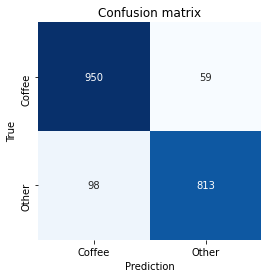

In [19]:
test_generator = generator(path_test, 
                            y_test, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE)
restored_model.evaluate(test_generator,steps=30)
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

## Culture vs no culture

In [8]:
culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree

nb_culture = 0
for c in culture_list:
    nb_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

nb_no_culture = 0
for c in no_culture_list:
    nb_no_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

In [9]:
path_culture = []

for c in culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_culture.append(os.path.join(IMAGES_DIR, str(c), name))
np.random.shuffle(path_culture)
class_culture = [0]*len(path_culture)
        
path_no_culture = []

for c in no_culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_no_culture.append(os.path.join(IMAGES_DIR, str(c), name))
np.random.shuffle(path_no_culture)
class_no_culture = [1]*len(path_no_culture)

In [10]:
file_paths = np.asarray(path_culture + path_no_culture)
classes = np.asarray(class_culture + class_no_culture)

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.25, random_state=42)

In [11]:
BATCH_SIZE = 64
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 2
EPOCH = 100
RUN_NAME = 'transfer_culture_vietnam_params'
LOGS_PATH = 'logs'

In [13]:
train_generator = generator(path_train, y_train, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)

## Model creation

In [12]:
model_culture = create_model()
model_culture.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv5_block27_2_conv (Conv2D)   (None, 2, 2, 32)     36864       conv5_block27_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block27_concat (Concatena (None, 2, 2, 1760)   0           conv5_block26_concat[0][0]       
                                                                 conv5_block27_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block28_0_bn (BatchNormal (None, 2, 2, 1760)   7040        conv5_block27_concat[0][0]       
__________________________________________________________________________________________________
conv5_block28_0_relu (Activatio (None, 2, 2, 1760)   0           conv5_block28_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block28_1_conv (Conv2D)   (None, 2, 2, 128)    225280      conv5_block28_0_relu[0][0]       
__________

In [16]:
# Run only for modify input shape
model_culture = change_model(model_culture, new_input_shape=(None, 32,32,13))
model_culture.summary()

Loaded layer input_1
Loaded layer zero_padding2d
Loaded layer conv1/conv
Loaded layer conv1/bn
Loaded layer conv1/relu
Loaded layer zero_padding2d_1
Loaded layer pool1
Loaded layer conv2_block1_0_bn
Loaded layer conv2_block1_0_relu
Loaded layer conv2_block1_1_conv
Loaded layer conv2_block1_1_bn
Loaded layer conv2_block1_1_relu
Loaded layer conv2_block1_2_conv
Loaded layer conv2_block1_concat
Loaded layer conv2_block2_0_bn
Loaded layer conv2_block2_0_relu
Loaded layer conv2_block2_1_conv
Loaded layer conv2_block2_1_bn
Loaded layer conv2_block2_1_relu
Loaded layer conv2_block2_2_conv
Loaded layer conv2_block2_concat
Loaded layer conv2_block3_0_bn
Loaded layer conv2_block3_0_relu
Loaded layer conv2_block3_1_conv
Loaded layer conv2_block3_1_bn
Loaded layer conv2_block3_1_relu
Loaded layer conv2_block3_2_conv
Loaded layer conv2_block3_concat
Loaded layer conv2_block4_0_bn
Loaded layer conv2_block4_0_relu
Loaded layer conv2_block4_1_conv
Loaded layer conv2_block4_1_bn
Loaded layer conv2_bloc

Loaded layer conv4_block23_concat
Loaded layer conv4_block24_0_bn
Loaded layer conv4_block24_0_relu
Loaded layer conv4_block24_1_conv
Loaded layer conv4_block24_1_bn
Loaded layer conv4_block24_1_relu
Loaded layer conv4_block24_2_conv
Loaded layer conv4_block24_concat
Loaded layer conv4_block25_0_bn
Loaded layer conv4_block25_0_relu
Loaded layer conv4_block25_1_conv
Loaded layer conv4_block25_1_bn
Loaded layer conv4_block25_1_relu
Loaded layer conv4_block25_2_conv
Loaded layer conv4_block25_concat
Loaded layer conv4_block26_0_bn
Loaded layer conv4_block26_0_relu
Loaded layer conv4_block26_1_conv
Loaded layer conv4_block26_1_bn
Loaded layer conv4_block26_1_relu
Loaded layer conv4_block26_2_conv
Loaded layer conv4_block26_concat
Loaded layer conv4_block27_0_bn
Loaded layer conv4_block27_0_relu
Loaded layer conv4_block27_1_conv
Loaded layer conv4_block27_1_bn
Loaded layer conv4_block27_1_relu
Loaded layer conv4_block27_2_conv
Loaded layer conv4_block27_concat
Loaded layer conv4_block28_0_b

Loaded layer conv5_block17_concat
Loaded layer conv5_block18_0_bn
Loaded layer conv5_block18_0_relu
Loaded layer conv5_block18_1_conv
Loaded layer conv5_block18_1_bn
Loaded layer conv5_block18_1_relu
Loaded layer conv5_block18_2_conv
Loaded layer conv5_block18_concat
Loaded layer conv5_block19_0_bn
Loaded layer conv5_block19_0_relu
Loaded layer conv5_block19_1_conv
Loaded layer conv5_block19_1_bn
Loaded layer conv5_block19_1_relu
Loaded layer conv5_block19_2_conv
Loaded layer conv5_block19_concat
Loaded layer conv5_block20_0_bn
Loaded layer conv5_block20_0_relu
Loaded layer conv5_block20_1_conv
Loaded layer conv5_block20_1_bn
Loaded layer conv5_block20_1_relu
Loaded layer conv5_block20_2_conv
Loaded layer conv5_block20_concat
Loaded layer conv5_block21_0_bn
Loaded layer conv5_block21_0_relu
Loaded layer conv5_block21_1_conv
Loaded layer conv5_block21_1_bn
Loaded layer conv5_block21_1_relu
Loaded layer conv5_block21_2_conv
Loaded layer conv5_block21_concat
Loaded layer conv5_block22_0_b

__________________________________________________________________________________________________
conv4_block15_0_bn (BatchNormal (None, 2, 2, 704)    2816        conv4_block14_concat[0][0]       
__________________________________________________________________________________________________
conv4_block15_0_relu (Activatio (None, 2, 2, 704)    0           conv4_block15_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block15_1_conv (Conv2D)   (None, 2, 2, 128)    90112       conv4_block15_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_bn (BatchNormal (None, 2, 2, 128)    512         conv4_block15_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_relu (Activatio (None, 2, 2, 128)    0           conv4_block15_1_bn[0][0]         
__________

In [57]:
os.mkdir(os.path.join(LOGS_PATH, RUN_NAME))

earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
#tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/transfer_culture_vietnam_params'

In [58]:


model_culture.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model_culture.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper])

Epoch 1/100
174/174 [==============================] - 39s 188ms/step - loss: 1.7473 - accuracy: 0.5251 - val_loss: 1.6164 - val_accuracy: 0.5665
Epoch 2/100
174/174 [==============================] - 31s 177ms/step - loss: 1.6062 - accuracy: 0.5555 - val_loss: 1.4959 - val_accuracy: 0.6498
Epoch 3/100
174/174 [==============================] - 31s 177ms/step - loss: 1.4909 - accuracy: 0.5773 - val_loss: 1.3913 - val_accuracy: 0.6856
Epoch 4/100
174/174 [==============================] - ETA: 0s - loss: 1.3893 - accuracy: 0.6003

KeyboardInterrupt: 

In [18]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

model_culture.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.npy'),history.history)

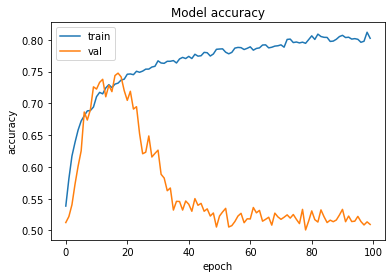

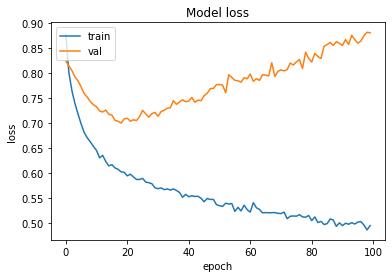

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model evaluation

In [20]:
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
model_culture.evaluate_generator(test_generator,30)

[0.46674337685108186, 0.8041667]

In [42]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(model_culture.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [43]:
cm = confusion_matrix(Y_true, Y_pred)

In [41]:
plot_confusion_matrix(cm)

TypeError: plot_confusion_matrix() missing 2 required positional arguments: 'X' and 'y_true'

In [45]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1055
           1       0.75      0.73      0.74       865

    accuracy                           0.77      1920
   macro avg       0.76      0.76      0.76      1920
weighted avg       0.77      0.77      0.77      1920

F1-Score : 0.7366568914956012


## Cross Validation

In [14]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'cross_val_culture'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

In [15]:
kf = KFold(n_splits=NB_FOLD)

fold_index = 0

results = []

for train_index, validation_index in kf.split(path_train, y_train):
    
    print(f"Training for fold {fold_index}")

    train_generator = generator(path_train[train_index], 
                                y_train[train_index], 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)

    validation_generator = generator(path_train[validation_index], 
                               y_train[validation_index], 
                               eurosat_params['mean'], 
                               eurosat_params['std'], 
                               batch_size=BATCH_SIZE, 
                               is_data_augmentation=False)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
    
    model_culture = create_model()

    model_culture.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

    history = model_culture.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=int(len(path_train[train_index])/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=int(len(path_train[validation_index])/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper])

    model_culture.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model_culture.evaluate(validation_generator,steps=4)
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print("\n")

    
    K.clear_session()

    
    fold_index+=1


Training for fold 0
Epoch 1/100
148/148 [==============================] - 34s 182ms/step - loss: 0.8068 - accuracy: 0.7052 - val_loss: 0.5546 - val_accuracy: 0.8433
Epoch 2/100
148/148 [==============================] - 25s 168ms/step - loss: 0.5563 - accuracy: 0.8215 - val_loss: 0.4606 - val_accuracy: 0.8885
Epoch 3/100
148/148 [==============================] - 25s 168ms/step - loss: 0.5245 - accuracy: 0.8401 - val_loss: 0.4234 - val_accuracy: 0.8993
Epoch 4/100
148/148 [==============================] - 25s 167ms/step - loss: 0.4919 - accuracy: 0.8479 - val_loss: 0.4757 - val_accuracy: 0.8941
Epoch 5/100
148/148 [==============================] - 25s 170ms/step - loss: 0.4755 - accuracy: 0.8637 - val_loss: 0.3794 - val_accuracy: 0.9089
Epoch 6/100
148/148 [==============================] - 25s 171ms/step - loss: 0.4729 - accuracy: 0.8646 - val_loss: 0.3877 - val_accuracy: 0.9023
Epoch 7/100
148/148 [==============================] - 25s 171ms/step - loss: 0.4301 - accuracy: 0.8788 

Epoch 13/100
148/148 [==============================] - 25s 168ms/step - loss: 0.4379 - accuracy: 0.8819 - val_loss: 0.3670 - val_accuracy: 0.8967
Epoch 14/100
148/148 [==============================] - 25s 169ms/step - loss: 0.4200 - accuracy: 0.8794 - val_loss: 0.3446 - val_accuracy: 0.9097
Epoch 15/100
148/148 [==============================] - 25s 169ms/step - loss: 0.4469 - accuracy: 0.8775 - val_loss: 0.3393 - val_accuracy: 0.9019
Epoch 16/100
148/148 [==============================] - 24s 166ms/step - loss: 0.3886 - accuracy: 0.8995 - val_loss: 0.3584 - val_accuracy: 0.8980
Epoch 17/100
148/148 [==============================] - 24s 165ms/step - loss: 0.3980 - accuracy: 0.8919 - val_loss: 0.3214 - val_accuracy: 0.9214
Epoch 18/100
148/148 [==============================] - 24s 166ms/step - loss: 0.3963 - accuracy: 0.8919 - val_loss: 0.3480 - val_accuracy: 0.9032
Epoch 19/100
148/148 [==============================] - 25s 167ms/step - loss: 0.3997 - accuracy: 0.8810 - val_loss: 0

Epoch 69/100
148/148 [==============================] - 24s 165ms/step - loss: 0.3375 - accuracy: 0.9051 - val_loss: 0.2561 - val_accuracy: 0.9353
Epoch 70/100
148/148 [==============================] - 24s 163ms/step - loss: 0.3101 - accuracy: 0.9086 - val_loss: 0.2680 - val_accuracy: 0.9258
Epoch 71/100
148/148 [==============================] - 24s 164ms/step - loss: 0.3059 - accuracy: 0.9076 - val_loss: 0.2613 - val_accuracy: 0.9227
Epoch 72/100
148/148 [==============================] - 24s 165ms/step - loss: 0.3081 - accuracy: 0.9092 - val_loss: 0.2585 - val_accuracy: 0.9240
Epoch 73/100
148/148 [==============================] - 24s 166ms/step - loss: 0.3123 - accuracy: 0.9108 - val_loss: 0.2618 - val_accuracy: 0.9306
Epoch 74/100
148/148 [==============================] - 24s 165ms/step - loss: 0.3081 - accuracy: 0.9072 - val_loss: 0.2577 - val_accuracy: 0.9280
Epoch 75/100
148/148 [==============================] - 24s 164ms/step - loss: 0.3251 - accuracy: 0.9022 - val_loss: 0

Epoch 45/100
148/148 [==============================] - 24s 166ms/step - loss: 0.3242 - accuracy: 0.9039 - val_loss: 0.2944 - val_accuracy: 0.9097
Epoch 46/100
148/148 [==============================] - 24s 164ms/step - loss: 0.3291 - accuracy: 0.9084 - val_loss: 0.3043 - val_accuracy: 0.9180
Epoch 47/100
148/148 [==============================] - 24s 164ms/step - loss: 0.3226 - accuracy: 0.9055 - val_loss: 0.2805 - val_accuracy: 0.9262
Epoch 48/100
148/148 [==============================] - 24s 165ms/step - loss: 0.3216 - accuracy: 0.9042 - val_loss: 0.2807 - val_accuracy: 0.9171
Epoch 49/100
148/148 [==============================] - 24s 165ms/step - loss: 0.3238 - accuracy: 0.9050 - val_loss: 0.2797 - val_accuracy: 0.9232
Epoch 50/100
148/148 [==============================] - 24s 166ms/step - loss: 0.3293 - accuracy: 0.9055 - val_loss: 0.2738 - val_accuracy: 0.9206
Epoch 51/100
148/148 [==============================] - 24s 165ms/step - loss: 0.3365 - accuracy: 0.9027 - val_loss: 0

4/4 [==============================] - 0s 133ms/step - loss: 0.2710 - accuracy: 0.9180
Fold 3 loss : 0.27100101113319397
Fold 3 accuracy : 0.91796875


Training for fold 4
Epoch 1/100
148/148 [==============================] - 33s 178ms/step - loss: 0.7957 - accuracy: 0.7194 - val_loss: 0.5581 - val_accuracy: 0.8255
Epoch 2/100
148/148 [==============================] - 24s 166ms/step - loss: 0.5951 - accuracy: 0.8216 - val_loss: 0.5005 - val_accuracy: 0.8524
Epoch 3/100
148/148 [==============================] - 24s 166ms/step - loss: 0.5092 - accuracy: 0.8567 - val_loss: 0.4777 - val_accuracy: 0.8429
Epoch 4/100
148/148 [==============================] - 24s 166ms/step - loss: 0.5023 - accuracy: 0.8568 - val_loss: 0.4552 - val_accuracy: 0.8598
Epoch 5/100
148/148 [==============================] - 25s 167ms/step - loss: 0.4572 - accuracy: 0.8699 - val_loss: 0.4238 - val_accuracy: 0.8733
Epoch 6/100
148/148 [==============================] - 24s 166ms/step - loss: 0.4521 - accuracy: 0

In [53]:
losses, accs = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")

Mean accuracy : 0.9125
Stdev accuracy : 0.012499999999999999


Mean loss : 0.2805428922176361
Stdev loss : 0.0254475370728173


In [ ]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

## Model evaluation

In [54]:
restored_model = get_best_cross_val_model(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME), RUN_NAME, results, custom_objects={'LeakyReLU':LeakyReLU})

In [24]:
test_generator = generator(path_test, 
                            y_test, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE)
restored_model.evaluate(test_generator,steps=30)

30/30 [==============================] - 6s 130ms/step - loss: 0.2563 - accuracy: 0.9328


[0.25634971261024475, 0.932812511920929]

In [25]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(model_culture.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

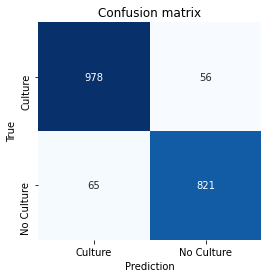

In [27]:
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No Culture"])

In [28]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1034
           1       0.94      0.93      0.93       886

    accuracy                           0.94      1920
   macro avg       0.94      0.94      0.94      1920
weighted avg       0.94      0.94      0.94      1920

F1-Score : 0.9313669880884855


In [29]:
pd.DataFrame({"path_train":path_train, "y_train":y_train}).to_csv("datasets/spring_train.csv", index=False)

In [30]:
pd.DataFrame({"path_test":path_test, "y_test":y_test}).to_csv("datasets/spring_test.csv", index=False)

# Performance 64x64 vs 32x32
## Coffee

In [83]:
history32 = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','32x32transfer', '32x32transfer.npy'),allow_pickle='TRUE').item()
history64 = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','cross_val_coffee_vietnam_1', 'cross_val_coffee_vietnam_1_0.npy'),allow_pickle='TRUE').item()

In [84]:
len(history64['loss'])

100

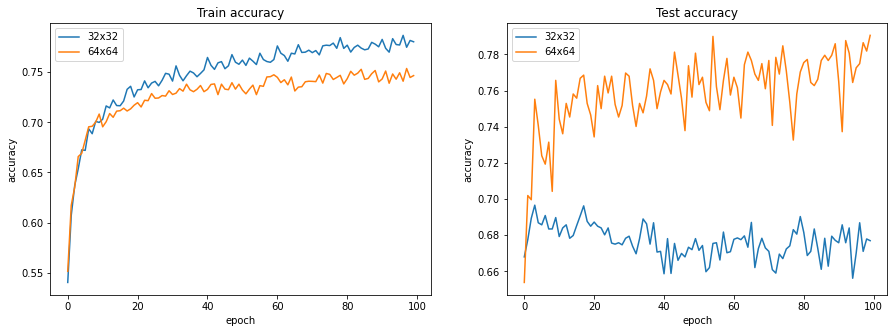

In [85]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['accuracy'])
axes[0].plot(history64['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_accuracy'])
axes[1].plot(history64['val_accuracy'])
axes[1].set_title('Test accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')

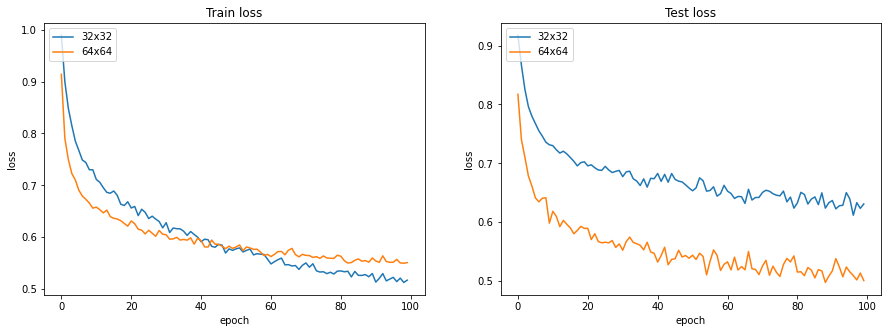

In [86]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['loss'])
axes[0].plot(history64['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_loss'])
axes[1].plot(history64['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')

## Culture vs no culture

In [12]:
history32 = np.load(os.path.join(SAVED_MODELS_PATH, 'Culture','32x32transfer_culture', '32x32transfer_culture.npy'),allow_pickle='TRUE').item()
history64 = np.load(os.path.join(SAVED_MODELS_PATH, 'Culture','transfer_learning_culture2', 'transfer_learning_culture2.npy'),allow_pickle='TRUE').item()

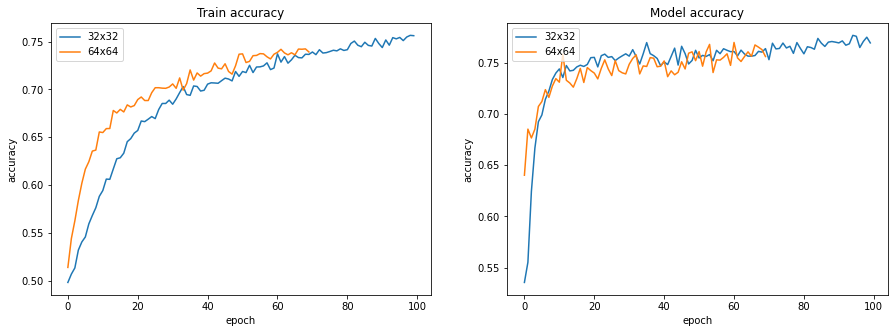

In [13]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['accuracy'])
axes[0].plot(history64['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_accuracy'])
axes[1].plot(history64['val_accuracy'])
axes[1].set_title('Model accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')

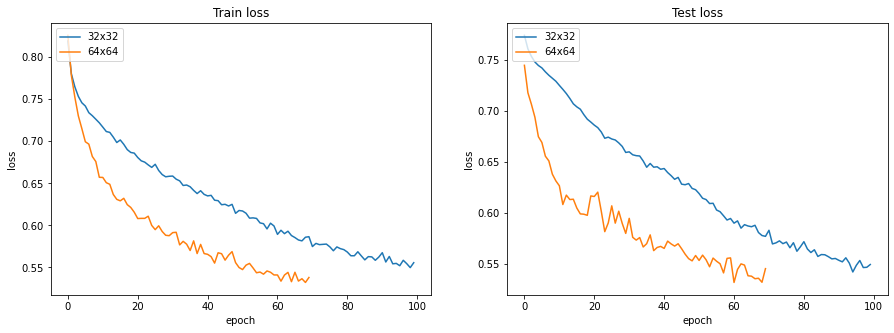

In [14]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['loss'])
axes[0].plot(history64['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_loss'])
axes[1].plot(history64['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')

# Spring vs rest

In [18]:
history_fall = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','trans_learning_fall', 'trans_learning_fall.npy'),allow_pickle='TRUE').item()
history_base = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','transfer_learning3', 'transfer_learning3.npy'),allow_pickle='TRUE').item()

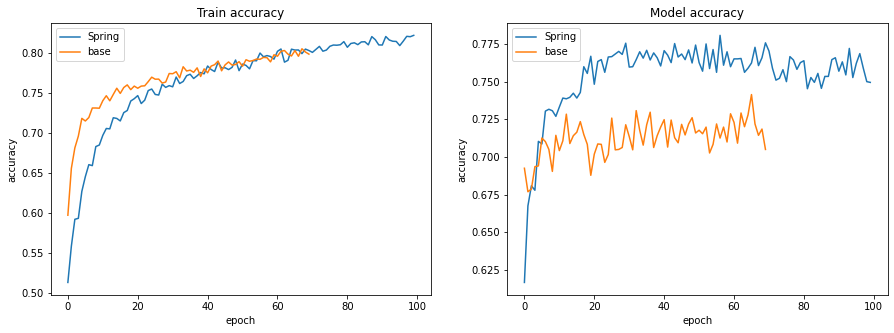

In [19]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_fall['accuracy'])
axes[0].plot(history_base['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['Spring', 'base'], loc='upper left')

axes[1].plot(history_fall['val_accuracy'])
axes[1].plot(history_base['val_accuracy'])
axes[1].set_title('Model accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['Spring', 'base'], loc='upper left')

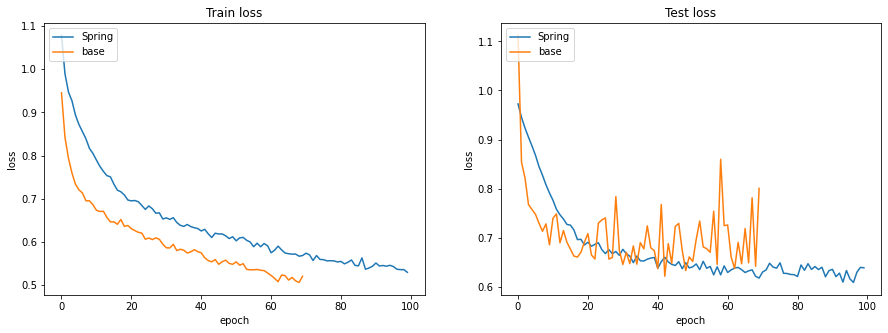

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_fall['loss'])
axes[0].plot(history_base['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['Spring', 'base'], loc='upper left')

axes[1].plot(history_fall['val_loss'])
axes[1].plot(history_base['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['Spring', 'base'], loc='upper left')

# Vietnam vs Eurosat

In [21]:
history_viet = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','trans_learning_viet_params', 'trans_learning_viet_params.npy'),allow_pickle='TRUE').item()
history_base = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','transfer_learning3', 'transfer_learning3.npy'),allow_pickle='TRUE').item()

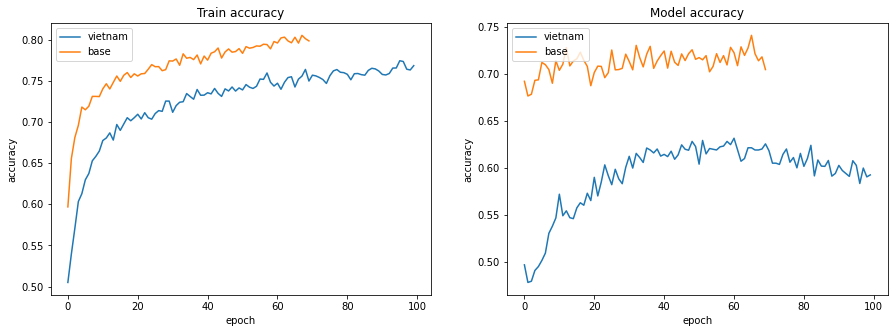

In [22]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_viet['accuracy'])
axes[0].plot(history_base['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['vietnam', 'base'], loc='upper left')

axes[1].plot(history_viet['val_accuracy'])
axes[1].plot(history_base['val_accuracy'])
axes[1].set_title('Model accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['vietnam', 'base'], loc='upper left')

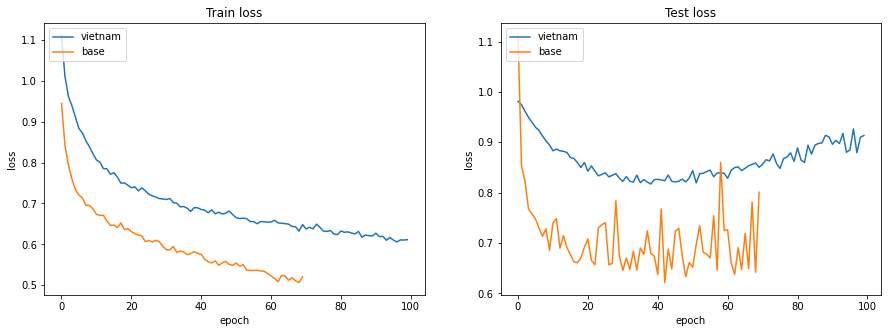

In [23]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_viet['loss'])
axes[0].plot(history_base['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['vietnam', 'base'], loc='upper left')

axes[1].plot(history_viet['val_loss'])
axes[1].plot(history_base['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['vietnam', 'base'], loc='upper left')

## Model comparison

In [15]:
data_test = pd.read_csv(os.path.join('datasets', 'all_test.csv'))

path_test = data_test['path_test'].to_numpy()
y_test = data_test['y_test'].to_numpy()

BATCH_SIZE=64

## Classic params

In [21]:
results = None
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', 'final_cv_coffee_vietnam_1', 'final_cv_coffee_vietnam_1.json')) as json_file:
    results = json.load(json_file)

In [22]:
losses, accs = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")

Mean accuracy : 0.75703125
Stdev accuracy : 0.033457207977131025


Mean loss : 0.720274555683136
Stdev loss : 0.12481706405182705


30/30 [==============================] - 6s 135ms/step - loss: 0.6926 - accuracy: 0.7630
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       933
           1       0.82      0.70      0.76       987

    accuracy                           0.77      1920
   macro avg       0.77      0.77      0.77      1920
weighted avg       0.77      0.77      0.77      1920

F1-Score : 0.7570806100217865


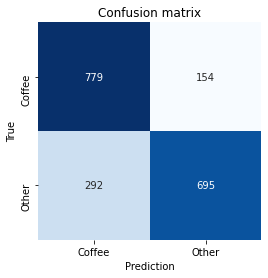

In [23]:
restored_model = get_best_cross_val_model(os.path.join(SAVED_MODELS_PATH, 'Coffee', 'final_cv_coffee_vietnam_1'), 'final_cv_coffee_vietnam_1', results, custom_objects={'LeakyReLU':LeakyReLU})
test_generator = generator(path_test, 
                            y_test, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE)
restored_model.evaluate(test_generator,steps=30)
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

## Spring

In [26]:
data_test = pd.read_csv(os.path.join('datasets', 'spring_test.csv'))

path_test = data_test['path_test'].to_numpy()
y_test = data_test['y_test'].to_numpy()

BATCH_SIZE=64

In [27]:
results = None
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', 'final_cv_coffee_fall_1', 'final_cv_coffee_fall_1.json')) as json_file:
    results = json.load(json_file)

In [28]:
losses, accs = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")

Mean accuracy : 0.91328125
Stdev accuracy : 0.019515618744994995


Mean loss : 0.3725772678852081
Stdev loss : 0.07785066759607095


30/30 [==============================] - 6s 136ms/step - loss: 0.3147 - accuracy: 0.9161
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1022
           1       0.95      0.91      0.93       898

    accuracy                           0.93      1920
   macro avg       0.93      0.93      0.93      1920
weighted avg       0.93      0.93      0.93      1920

F1-Score : 0.9271899886234357


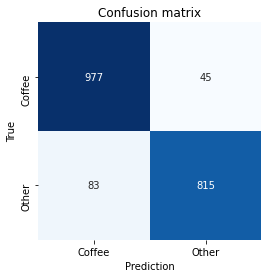

In [29]:
restored_model = get_best_cross_val_model(os.path.join(SAVED_MODELS_PATH, 'Coffee', 'final_cv_coffee_fall_1'), 'final_cv_coffee_fall_1', results, custom_objects={'LeakyReLU':LeakyReLU})
test_generator = generator(path_test, 
                            y_test, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE)
restored_model.evaluate(test_generator,steps=30)
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

## Culture vs no culture

In [30]:
data_test = pd.read_csv(os.path.join('datasets', 'spring_test.csv'))

path_test = data_test['path_test'].to_numpy()
y_test = data_test['y_test'].to_numpy()

BATCH_SIZE=64

In [33]:
results = None
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', 'cross_val_culture', 'cross_val_culture.json')) as json_file:
    results = json.load(json_file)

In [34]:
losses, accs = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")

Mean accuracy : 0.9125
Stdev accuracy : 0.012499999999999999


Mean loss : 0.2805428922176361
Stdev loss : 0.0254475370728173


30/30 [==============================] - 6s 138ms/step - loss: 0.2336 - accuracy: 0.9438
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       994
           1       0.95      0.93      0.94       926

    accuracy                           0.94      1920
   macro avg       0.94      0.94      0.94      1920
weighted avg       0.94      0.94      0.94      1920

F1-Score : 0.9379760609357998


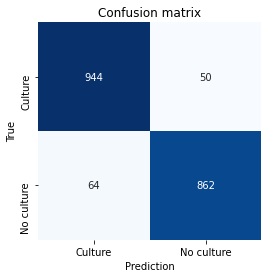

In [36]:
restored_model = get_best_cross_val_model(os.path.join(SAVED_MODELS_PATH, 'Culture', 'cross_val_culture'), 'cross_val_culture', results, custom_objects={'LeakyReLU':LeakyReLU})
test_generator = generator(path_test, 
                            y_test, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE)
restored_model.evaluate(test_generator,steps=30)
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No culture"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")